In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline
import seaborn as sns
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import datetime

In [114]:
#Load in the data

df_calendar = pd.read_csv('/Users/Caddi/Data/BerlinAirbnb/calendar.csv')
df_listings = pd.read_csv('/Users/Caddi/Data/BerlinAirbnb/listings.csv')
df_reviews = pd.read_csv('/Users/Caddi/Data/BerlinAirbnb/reviews.csv')

In [145]:
df_listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2695,https://www.airbnb.com/rooms/2695,20190514043746,2019-05-14,Prenzlauer Berg close to Mauerpark,NaN,In the summertime we are spending most of our ...,In the summertime we are spending most of our ...,none,NaN,...,f,f,moderate,f,f,1,0,1,0,0.67
1,3176,https://www.airbnb.com/rooms/3176,20190514043746,2019-05-14,Fabulous Flat in great Location,This beautiful first floor apartment is situa...,1st floor (68m2) apartment on Kollwitzplatz/ P...,This beautiful first floor apartment is situa...,none,The neighbourhood is famous for its variety of...,...,f,f,strict_14_with_grace_period,f,f,1,1,0,0,1.19
2,7071,https://www.airbnb.com/rooms/7071,20190514043746,2019-05-14,BrightRoom with sunny greenview!,Cozy and large room in the beautiful district ...,"The BrightRoom is an approx. 20 sqm (215ft²), ...",Cozy and large room in the beautiful district ...,none,"Great neighborhood with plenty of Cafés, Baker...",...,f,f,moderate,f,f,2,0,2,0,1.93
3,9991,https://www.airbnb.com/rooms/9991,20190514043746,2019-05-14,Geourgeous flat - outstanding views,4 bedroom with very large windows and outstand...,"THE APPARTMENT - 4 bedroom (US, Germany: 5 roo...",4 bedroom with very large windows and outstand...,none,Prenzlauer Berg is an amazing neighbourhood wh...,...,f,f,strict_14_with_grace_period,f,f,1,1,0,0,0.13
4,14325,https://www.airbnb.com/rooms/14325,20190514043746,2019-05-14,Apartment in Prenzlauer Berg,The apartment is located on the upper second f...,The apartment is located on the south-facing s...,The apartment is located on the upper second f...,none,NaN,...,f,f,strict_14_with_grace_period,f,f,4,4,0,0,0.21


In a first step, we will explore the datasets. 

In [146]:
# First, the listings data
# Print rows and columns in calendar data set
print("Number of rows and columns: ", df_listings.shape)
# Assess null values
print(df_listings.isnull().sum())

Number of rows and columns:  (23536, 106)
id                                                  0
listing_url                                         0
scrape_id                                           0
last_scraped                                        0
name                                               54
summary                                          1069
space                                            8410
description                                       297
experiences_offered                                 0
neighborhood_overview                           10776
notes                                           15779
transit                                          9289
access                                          12215
interaction                                     11986
house_rules                                     11540
thumbnail_url                                   23536
medium_url                                      23536
picture_url                             

In [147]:
#Find columns with many missing values
#df_listings.isna().mean()



In [148]:
# drop columns that where all entries are equal
irrelevant=[]
for col in listings.columns:
    if listings[col].nunique() == 1 :
        irrelevant.append(col)
print(irrelevant)        

[]


We drop  columns that are not useful for our model, e.g hyperlinks, host names, text descriptons ( as we are not performing sentiment analysis). We also drop to refined spatial information, like 'latitude', 'longitude'.


In [189]:
# drop columns that are not relevant for prediction
cols = [ 'host_since', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 
             'host_is_superhost', \
             'host_identity_verified', 'city', 'neighbourhood_group_cleansed', \
              'property_type', 'room_type', 'accommodates', 'bathrooms', \
             'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet', 'price', 'weekly_price', \
             'monthly_price', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', \
             'minimum_nights', 'maximum_nights', 'availability_365', 'number_of_reviews', \
             'first_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', \
             'review_scores_checkin', 'review_scores_communication', 'review_scores_value', 'requires_license', \
             'license', 'instant_bookable', 'cancellation_policy', 'require_guest_profile_picture', \
             'require_guest_phone_verification', 'calculated_host_listings_count', 'reviews_per_month']
listings = df_listings[cols]

listings.head(2)


,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_identity_verified,city,neighbourhood_group_cleansed,property_type,room_type,...,review_scores_communication,review_scores_value,requires_license,license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,2008-09-16,within a day,50%,NaN,f,t,Berlin,Pankow,Apartment,Private room,...,10.0,10.0,t,NaN,f,moderate,f,f,1,0.67
1,2008-10-19,within a day,50%,NaN,f,t,Berlin,Pankow,Apartment,Entire home/apt,...,9.0,9.0,t,NaN,f,strict_14_with_grace_period,f,f,1,1.19


In [190]:
# find columns that have more than thresh percent of missing values
thresh = 0.70
droplist = []
drop_dic = {}
for col in listings.columns:
    if listings[col].isna().mean() >= thresh :
        droplist.append(col)
        drop_dic[col] = listings[col].isna().mean()

   
#df_listings_drop = listings.drop( droplist, axis =1 )

print(drop_dic)        
        
      

{'host_acceptance_rate': 1.0, 'square_feet': 0.9819425560842964, 'weekly_price': 0.8550305914343984, 'monthly_price': 0.8953093133922502, 'license': 0.9069085656016316}


Of the columns we drop, weekly_price and monthly_price are just other measures of price, so we can safely discard them. host_acceptance_rate, square_feet and license have too many missing values to keep (above 90%). The remaining colums have less than 70% missing values. We will try to fill these in. 

In [191]:
listings_drop = listings.drop( droplist, axis =1 )  

To get a better feel for the missing values, we calculate a histogramm.


host_response_time             0.445700
host_response_rate             0.445700
security_deposit               0.397561
cleaning_fee                   0.301028
review_scores_value            0.198334
review_scores_checkin          0.198249
review_scores_communication    0.197570
review_scores_accuracy         0.197485
review_scores_cleanliness      0.197315
review_scores_rating           0.196380
dtype: float64

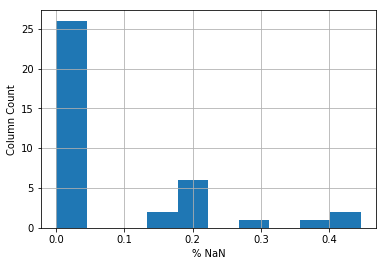

In [192]:

nan_cols = (listings_drop.isnull().mean()).sort_values(ascending = False)
ax = nan_cols.hist()  
ax.set_xlabel("% NaN")
ax.set_ylabel("Column Count")
nan_cols.head(n=10)


In [193]:
# Review all the numerical columns and assess missing values

num_cols = listings_drop.select_dtypes(include=['float', 'int']).columns
for col in num_cols:
    print(col,listings_drop[col].isnull().sum())

accommodates 0
bathrooms 29
bedrooms 20
beds 35
guests_included 0
minimum_nights 0
maximum_nights 0
availability_365 0
number_of_reviews 0
review_scores_rating 4622
review_scores_accuracy 4648
review_scores_cleanliness 4644
review_scores_checkin 4666
review_scores_communication 4650
review_scores_value 4668
calculated_host_listings_count 0
reviews_per_month 4156


We will set all NaN values in beds, bedrooms and bathrooms to 1. 

The review scores columns will be set to 0 as we will assume that there are no reviews.

In [194]:
# Impute the missing values.
for col in num_cols :
    if col in ['bathrooms','bedrooms','beds'] :
        listings_drop[col] = listings_drop[col].fillna(1)
    else :
        listings_drop[col] = listings_drop[col].fillna(0)
        

In [195]:
# Review all the categorical columns and assess missing values

cat_cols = listings_drop.select_dtypes(include=['object']).columns
for col in cat_cols:
        print(col,listings_drop[col].isnull().sum())

host_since 21
host_response_time 10490
host_response_rate 10490
host_is_superhost 21
host_identity_verified 21
city 3
neighbourhood_group_cleansed 0
property_type 0
room_type 0
bed_type 0
amenities 0
price 0
security_deposit 9357
cleaning_fee 7085
extra_people 0
first_review 4156
requires_license 0
instant_bookable 0
cancellation_policy 0
require_guest_profile_picture 0
require_guest_phone_verification 0


host_response_time and host_response_rate. host_since seem to have not available as valid entry, so we replace nan by the string 'N/A'

host_is_superhost, host_identity_verified  we will set to false for NaN. 

city we set to Berlin

security_deposit and cleaning_fee we will set to 0, assuming that there is none in the NaN case.

In the code below, we see that missing values in first_review indicate that there are no reviews. We will convert this column into time_since_first_review. 


In [196]:
# check that all NaN in first_review have no review
temp = listings_drop.loc[(listings_drop['first_review'].isnull() == 1) &( listings_drop['reviews_per_month']== 0)] 
print(temp.shape)

(4156, 38)


In [197]:
def conversion(date_time_str):
    date_time_obj = datetime.datetime.strptime(date_time_str, '%Y-%m-%d')
    date = datetime.datetime.strptime('2019-07-22', '%Y-%m-%d')
    date1 = date.date()
    date2 = date_time_obj.date()
    delta = date1 - date2
    return delta.days

In [198]:
# Impute the missing values.
date_str = '2019-07-22'


listings_drop['first_review'] = listings_drop['first_review'].fillna(date_str)
listings_drop['city'] = listings_drop['city'].fillna('Berlin')

temp = [ e for e in cat_cols if not e in ('first_review', 'city')]    
    
for col in temp :
    if col in ['host_response_time', 'host_response_rate', 'host_since'] :
        listings_drop[col] = listings_drop[col].fillna('N/A')
    else :
        listings_drop[col] = listings_drop[col].fillna(0)
 

# create new colum 
listings_drop['time_first'] = listings_drop['first_review'].apply(conversion)

We check that there are 61 unique values in the 'city' column. Most of them are variants of Berlin, but a number of them are in fact places outside of Berlin. We will drop those. 

In [199]:
listings_drop['city'].unique()

array(['Berlin', 'Berlin (Kreuzberg)', 'Friedrichshain',
       'Berlin / Kleinmachnow', 'Berlin-Wedding', 'Mitte', 'Berlin-Mitte',
       'Weissensee, Berlin', 'Woltersdorf', 'Berlin-Treptow',
       'Kleinmachnow', 'Berlin-Friedrichshain',
       'Baseler Straße 91 A, 12205 Berlin ', 'Berlin-Neukölln',
       'Berlin-Zehlendorf', 'Baseler Straße 91 A,12205 Berlin',
       'Berlin, Charlottenburg', 'Βερολίνο', 'Berlin-Tiergarten',
       'Kreuzberg, Berlin', 'Berlino', 'Berlin ', 'Berlín',
       'Berlin - Schöneberg', 'Берлин', 'Berlim', '柏林', 'Berlin Neukölln',
       'Berlin/Steglitz', 'Berlin - Mitte', 'Prenzlauer Berg',
       'Berlin, friedrichshain ', 'Berlin- Charlottenburg',
       'Berlin-Wilmersdorf', 'Wannsee', 'Berlin, Schöneberg', 'berlin',
       'Berlin (Wedding)', 'Mitte/Tiergarten', 'Köpenick',
       'Mitte/Kreuzberg', 'Berlin Friedrichshain',
       'Berlin Prenzlauer Berg ', '10999 Berlin', 'Wilmersdorf', 'Erkner',
       'Berlin, Berlin, DE', 'Schöneberg', 'Hoppe

In [200]:
notBerlin = ('Zeuthen', 'Kleinmachnow', 'Woltersdorf', 
             'Köpenick', 'Erkner', 'Hoppegarten', 'Hennigsdorf', 'Eichwalde' )



def indicator(x):
    if x in notBerlin :
        return 1
    return 0

listings_drop['Berlin'] = listings_drop['city'].apply(indicator)


In [201]:
df_list = listings_drop[listings_drop['Berlin'] == 0]

df_list = df_list.drop( ['city','first_review', 'Berlin'], axis =1 )  

In [202]:
#Check there are no NaN in this list

print(df_list.isnull().sum())

host_since                          0
host_response_time                  0
host_response_rate                  0
host_is_superhost                   0
host_identity_verified              0
neighbourhood_group_cleansed        0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                           0
bedrooms                            0
beds                                0
bed_type                            0
amenities                           0
price                               0
security_deposit                    0
cleaning_fee                        0
guests_included                     0
extra_people                        0
minimum_nights                      0
maximum_nights                      0
availability_365                    0
number_of_reviews                   0
review_scores_rating                0
review_scores_accuracy              0
review_scores_cleanliness           0
review_score

In [205]:
cat_cols = df_list.select_dtypes(include=['object']).columns
for col in cat_cols:
        print(col,listings_drop[col].nunique())

host_since 3086
host_response_time 5
host_response_rate 76
host_is_superhost 3
host_identity_verified 3
neighbourhood_group_cleansed 12
property_type 35
room_type 3
bed_type 5
amenities 20854
price 326
security_deposit 161
cleaning_fee 119
extra_people 66
requires_license 2
instant_bookable 2
cancellation_policy 6
require_guest_profile_picture 2
require_guest_phone_verification 2


In [ ]:
#NEXT convert price, sec deposit, fee, extra people to prices and host to a continuous variable